In [1]:
import numpy as np
import scipy as sc
from scipy import io
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline
import json

plt.rcParams['text.usetex'] = True
%config InlineBackend.figure_format = 'retina'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 18

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

from qpfs import QPFS, MultivariateQPFS, MinimaxQPFS
from stat_tests import t_test_corr, check_correlation

lr = LinearRegression()

In [2]:
def get_autoreg_Y(Y, step=1):
    m, t = Y.shape
    ar = np.zeros((m - step + 1, t * step))
    for i in range(step):
        for k in range(t):
            ar[:, i * t + k] = Y[i: m + i - step + 1, k]

    return ar


def get_corr(X, Y=None, fill=0):
    if Y is None:
        Y = X
    if len(Y.shape) == 1:
        Y = Y[:, np.newaxis]
        Y = np.atleast_2d(Y)
    if len(X.shape) == 1:
        X = X[:, np.newaxis]
    
    X_ = (X - X.mean(axis=0))
    Y_ = (Y - Y.mean(axis=0))
    
    idxs_nz_x = np.where(np.sum(X_ ** 2, axis = 0) != 0)[0]
    idxs_nz_y = np.where(np.sum(Y_ ** 2, axis = 0) != 0)[0]
    
    X_ = X_[:, idxs_nz_x]
    Y_ = Y_[:, idxs_nz_y]
    
    corr = np.ones((X.shape[1], Y.shape[1])) * fill
    
    for i, x in enumerate(X_.T):
        corr[idxs_nz_x[i], idxs_nz_y] = Y_.T.dot(x) / np.sqrt(np.sum(x ** 2) * np.sum(Y_ ** 2, axis=0, keepdims=True))
    return corr

In [3]:
def RMSE(y, p):
    return np.sqrt(np.mean((y - p) ** 2))


def metric_vif(active_idxs):
    with open('res/ecog_vifx.json', 'r') as f:
        vifx = np.array(json.loads(f.read()))[active_idxs]
    return np.max(vifx)


def metric_stability(X):
    ev = np.linalg.eigh(X.T.dot(X))[0]
    return np.log(ev[0] / ev[-1])


def metric_complexity(X):
    return X.shape[1]


def metric_rmse(X, y, est=None):
    if est is None:
        est = LinearRegression()
        est.fit(X, y)
    y_pred = est.predict(X)
    return np.sqrt(np.mean((y - y_pred) ** 2))


def metric_bic(X, y, est=None):
    if est is None:
        est = LinearRegression()
        est.fit(X, y)
    y_pred = est.predict(X)
    m, p = X.shape
    return np.log(np.sum((y_pred - y) ** 2) / m) + p * np.log(m) * y.shape[1] / m


def metric_aic(X, y, est=None):
    if est is None:
        est = LinearRegression()
        est.fit(X, y)
    y_pred = est.predict(X)
    m, p = X.shape
    r = 1 if len(y.shape) == 1 else y.shape[1]
    return np.log(np.sum((y_pred - y) ** 2) / m) + 2 * r * p / m


def metric_mse(X, Y):
    m, p = X.shape
    est = LinearRegression()
    est.fit(X, Y)
    pred = est.predict(X)
    return np.linalg.det(Y.T.dot(Y - pred)) / (m - p)
    
    
def metric_aic(X, Y):
    m, p = X.shape
    r = Y.shape[1]
    est = LinearRegression()
    est.fit(X, Y)
    pred = est.predict(X)
    return np.log(np.linalg.det(Y.T.dot(Y - pred))) + 2 * p * r / m
    

def metric_hq(X, Y):
    m, p = X.shape
    r = Y.shape[1]
    est = LinearRegression()
    est.fit(X, Y)
    pred = est.predict(X)
    return np.log(np.linalg.det(Y.T.dot(Y - pred))) + 2 * np.log(np.log(m)) * p * r / m


def metric_bic(X, Y):
    m, p = X.shape
    r = Y.shape[1]
    est = LinearRegression()
    est.fit(X, Y)
    pred = est.predict(X)
    return 2 * np.log(np.linalg.det(Y.T.dot(Y - pred))) + np.log(m) * p / m


def metric_corr(Q, b, active_idxs):
    b = b[active_idxs]
    Q = Q[active_idxs][:, active_idxs]
    return b.T.dot(np.linalg.pinv(Q)).dot(b)

In [65]:
def get_metrics(n_active_array, alpha3_array, score_history, Xtrain, Ytrain, Xtest, Ytest):
    results = {}
    results['score'] = []
    results['train_rmse'] =[]
    results['test_rmse'] = []
    results['stability'] = []
    results['vif'] = []
    results['aic'] = []
    results['bic'] = []
    results['hq'] = []
    results['mse'] = []
    results['corr'] = []
    results['alphas'] = alpha3_array.tolist()
    results['n_active_array'] = n_active_array.tolist()
    
    Q = get_corr(Xtrain)
    B = get_corr(Xtrain, Ytrain)
    
    for sh in tqdm_notebook(score_history):
        score = sh[:Xtrain.shape[1]]
        idxs_sort = score.argsort()[::-1]

        train_rmse = []
        test_rmse = []
        stability = []
        vif = []
        bic = []
        aic = []
        mse = []
        hq = []
        corr = []

        for k in n_active_array:
            active_idxs = idxs_sort[:k]
            lr.fit(Xtrain[:, active_idxs], Ytrain)
            train_rmse.append(metric_rmse(Xtrain[:, active_idxs], Ytrain, lr))
            test_rmse.append(metric_rmse(Xtest[:, active_idxs], Ytest, lr))
            stability.append(metric_stability(Xtrain[:, active_idxs]))
            vif.append(metric_vif(active_idxs))
            bic.append(metric_bic(Xtrain[:, active_idxs], Ytrain))
            aic.append(metric_aic(Xtrain[:, active_idxs], Ytrain))
            mse.append(metric_mse(Xtrain[:, active_idxs], Ytrain))
            hq.append(metric_hq(Xtrain[:, active_idxs], Ytrain))
            corr.append(np.mean(np.diag(metric_corr(Q, B, active_idxs))))

        results['score'].append(score[idxs_sort].tolist())
        results['train_rmse'].append(train_rmse)
        results['test_rmse'].append(test_rmse)
        results['stability'].append(stability)
        results['vif'].append(vif)
        results['bic'].append(bic)
        results['aic'].append(aic)
        results['mse'].append(mse)
        results['hq'].append(hq)
        results['corr'].append(corr)
        
    return results


def plot_metrics(results):
    fig, ax = plt.subplots(3, 2, figsize=(15, 10), sharex=True)
    for i, score in enumerate(results['score']):
        ax[0, 0].semilogy(score, label=results['alphas'][i])
    ax[0, 0].set_ylabel('Score')

    for i, train_rmse in enumerate(results['train_rmse']):
        ax[1, 0].plot(results['n_active_array'], train_rmse, label=results['alphas'][i])
    ax[1, 0].set_ylabel('RMSE train')

    for i, test_rmse in enumerate(results['test_rmse']):
        ax[2, 0].plot(results['n_active_array'], test_rmse, label=results['alphas'][i])
    ax[2, 0].set_ylabel('RMSE test')
    ax[2, 0].set_xlabel('Features')

    for i, stability in enumerate(results['stability']):
        ax[0, 1].plot(results['n_active_array'], stability, label=results['alphas'][i])
    ax[0, 1].set_ylabel('Stability')
    ax[0, 1].legend()
    
    for i, corr in enumerate(results['corr']):
        ax[1, 1].plot(results['n_active_array'], corr, label=results['alphas'][i])
    ax[1, 1].set_ylabel('Multicorrelation')
    
    for i, bic in enumerate(results['aic']):
        ax[2, 1].plot(results['n_active_array'], bic, label=results['alphas'][i])
    ax[2, 1].set_ylabel('AIC')
    ax[2, 1].set_xlabel('Features')

#     for i, hq in enumerate(results['hq']):
#         ax[3, 0].plot(results['n_active_array'], hq, label=results['alphas'][i])
#     ax[3, 0].set_ylabel('HQ')

#     for i, vif in enumerate(results['vif']):
#         ax[1, 1].plot(results['n_active_array'], vif, label=results['alphas'][i])
#     ax[1, 1].set_ylabel('VIF')
    
#     for i, mse in enumerate(results['mse']):
#         ax[3, 1].plot(results['n_active_array'], mse, label=results['alphas'][i])
#     ax[3, 1].set_ylabel('MSE')
    
#     for i, bic in enumerate(results['bic']):
#         ax[4, 1].plot(results['n_active_array'], bic, label=results['alphas'][i])
#     ax[4, 1].set_ylabel('BIC')
#     ax[4, 1].set_xlabel('Features')

    fig.tight_layout()
    plt.savefig('figs/ecog_3_{}_metrics.eps'.format(step), format='eps')
    plt.show()

In [66]:
Xtrain = sc.io.loadmat('./../data/ECoG_X_train.mat')['X_train'].reshape([-1, 32 * 27])
Ytrain = sc.io.loadmat('./../data/ECoG_Y_train.mat')['Y_train']

Xtest = sc.io.loadmat('./../data/ECoG_X_test.mat')['X_hold_out'].reshape([-1, 32 * 27])
Ytest = sc.io.loadmat('./../data/ECoG_Y_test.mat')['Y_hold_out']

n_samples, n_features = Xtrain.shape

print(Xtrain.shape, Ytrain.shape)
print(Xtest.shape, Ytest.shape)

(12801, 864) (12801, 3)
(6087, 864) (6087, 3)


In [67]:
lr.fit(Xtrain, Ytrain)

pred = lr.predict(Xtrain)
print('train: ', RMSE(Ytrain, pred))

pred = lr.predict(Xtest)
print('test: ', RMSE(Ytest, pred))

train:  38.441522087
test:  42.2703059983


In [68]:
qpfs = QPFS()
mqpfs = MultivariateQPFS()
mmqpfs_minmax = MinimaxQPFS(mode='minmax')
mmqpfs_maxmin = MinimaxQPFS(mode='maxmin')
mmqpfs_dual_woy = MinimaxQPFS(mode='dual_woy')

In [69]:
step = 1

Ytrain_ar, Ytest_ar = get_autoreg_Y(Ytrain, step), get_autoreg_Y(Ytest, step)
Xtrain_ar, Xtest_ar = Xtrain[:Xtrain.shape[0]-step + 1], Xtest[:Xtest.shape[0]-step + 1]

print(Ytrain_ar.shape, Xtrain_ar.shape, Ytest_ar.shape, Xtest_ar.shape)

(12801, 3) (12801, 864) (6087, 3) (6087, 864)


In [28]:
qpfs.fit(Xtrain_ar, Ytrain_ar)
mqpfs.fit(Xtrain_ar, Ytrain_ar)
mmqpfs_minmax.fit(Xtrain_ar, Ytrain_ar)
mmqpfs_maxmin.fit(Xtrain_ar, Ytrain_ar)
mmqpfs_dual_woy.fit(Xtrain_ar, Ytrain_ar)

In [29]:
score_history = [qpfs.score, mqpfs.score, mmqpfs_minmax.ax, mmqpfs_maxmin.ax, mmqpfs_dual_woy.ax]
n_active_array = np.arange(1, n_features, 20)

In [ ]:
algs = np.array(['RelAgg', 'SymImp', 'MinMax', 'MaxMin', 'MaxRel'])
results = get_metrics(n_active_array, algs, score_history, Xtrain_ar, Ytrain_ar, Xtest_ar, Ytest_ar)

with open('res/qpfs_vs_mqpfs_ecog_3_{}_results.json'.format(step), 'w') as f:
    f.write(json.dumps(results))

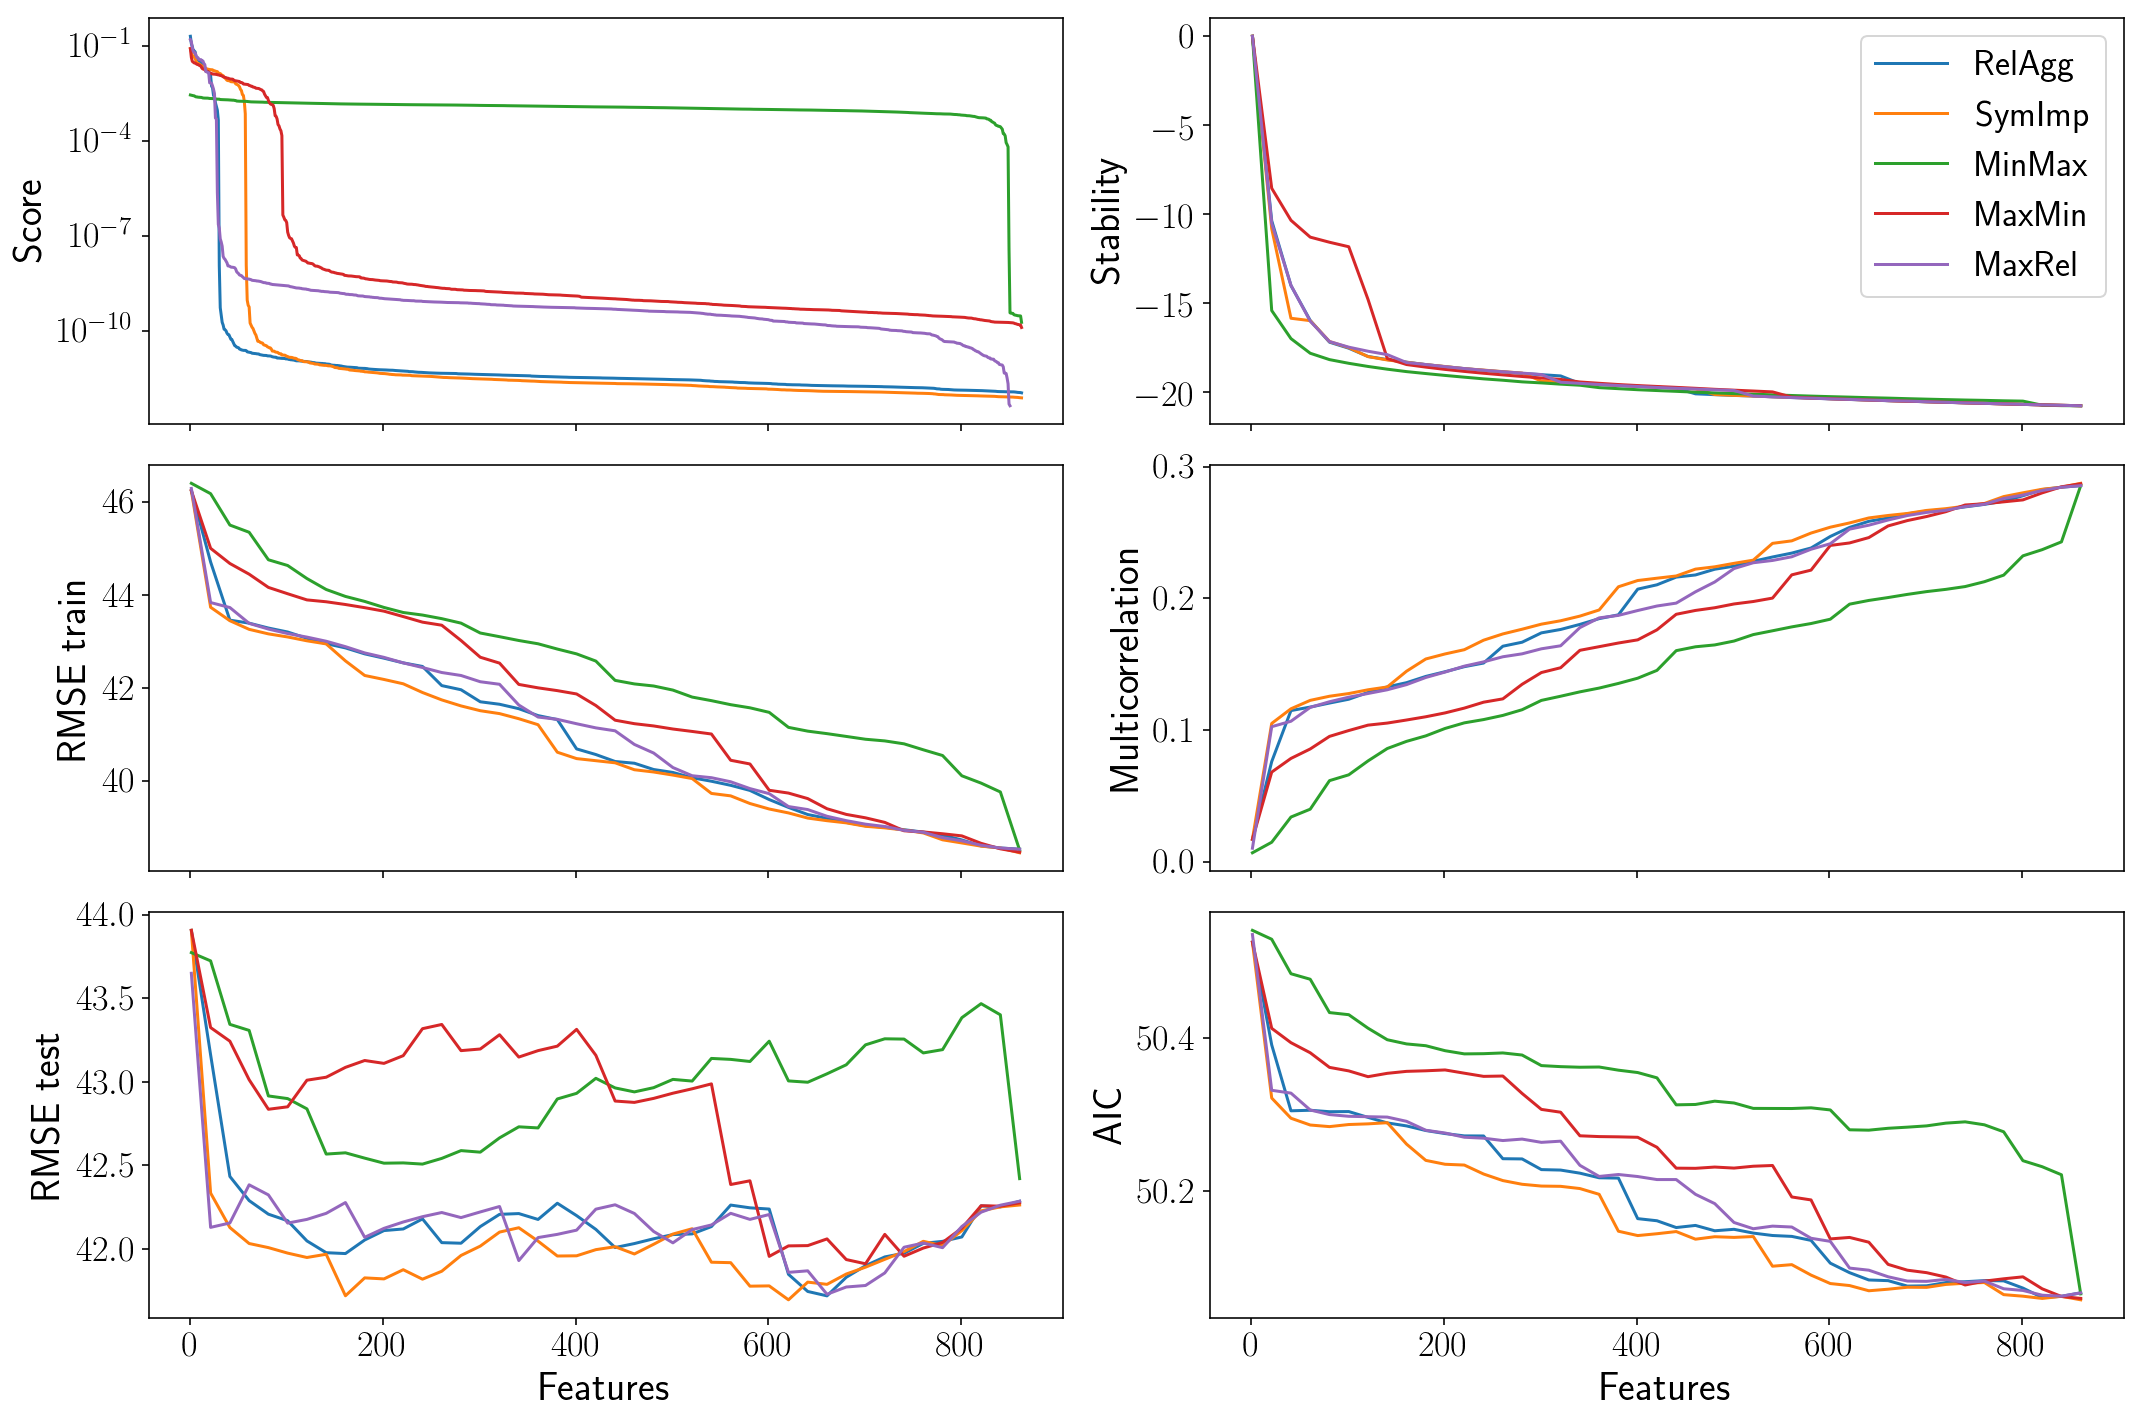

In [70]:
with open('res/qpfs_vs_mqpfs_ecog_3_{}_results.json'.format(step), 'r') as f:
    results = json.loads(f.read())

plot_metrics(results)

In [71]:
step = 15

Ytrain_ar, Ytest_ar = get_autoreg_Y(Ytrain, step), get_autoreg_Y(Ytest, step)
Xtrain_ar, Xtest_ar = Xtrain[:Xtrain.shape[0]-step + 1], Xtest[:Xtest.shape[0]-step + 1]

print(Ytrain_ar.shape, Xtrain_ar.shape, Ytest_ar.shape, Xtest_ar.shape)

(12787, 45) (12787, 864) (6073, 45) (6073, 864)


In [33]:
qpfs.fit(Xtrain_ar, Ytrain_ar)
mqpfs.fit(Xtrain_ar, Ytrain_ar)
mmqpfs_minmax.fit(Xtrain_ar, Ytrain_ar)
mmqpfs_maxmin.fit(Xtrain_ar, Ytrain_ar)
mmqpfs_dual_woy.fit(Xtrain_ar, Ytrain_ar)

In [34]:
score_history = [qpfs.score, mqpfs.score, mmqpfs_minmax.ax, mmqpfs_maxmin.ax, mmqpfs_dual_woy.ax]
n_active_array = np.arange(1, n_features, 20)

In [35]:
algs = np.array(['RelAgg', 'SymImp', 'MinMax', 'MaxMin', 'MaxRel'])
results = get_metrics(n_active_array, algs, score_history, Xtrain_ar, Ytrain_ar, Xtest_ar, Ytest_ar)

with open('res/qpfs_vs_mqpfs_ecog_3_{}_results.json'.format(step), 'w') as f:
    f.write(json.dumps(results))

A Jupyter Widget

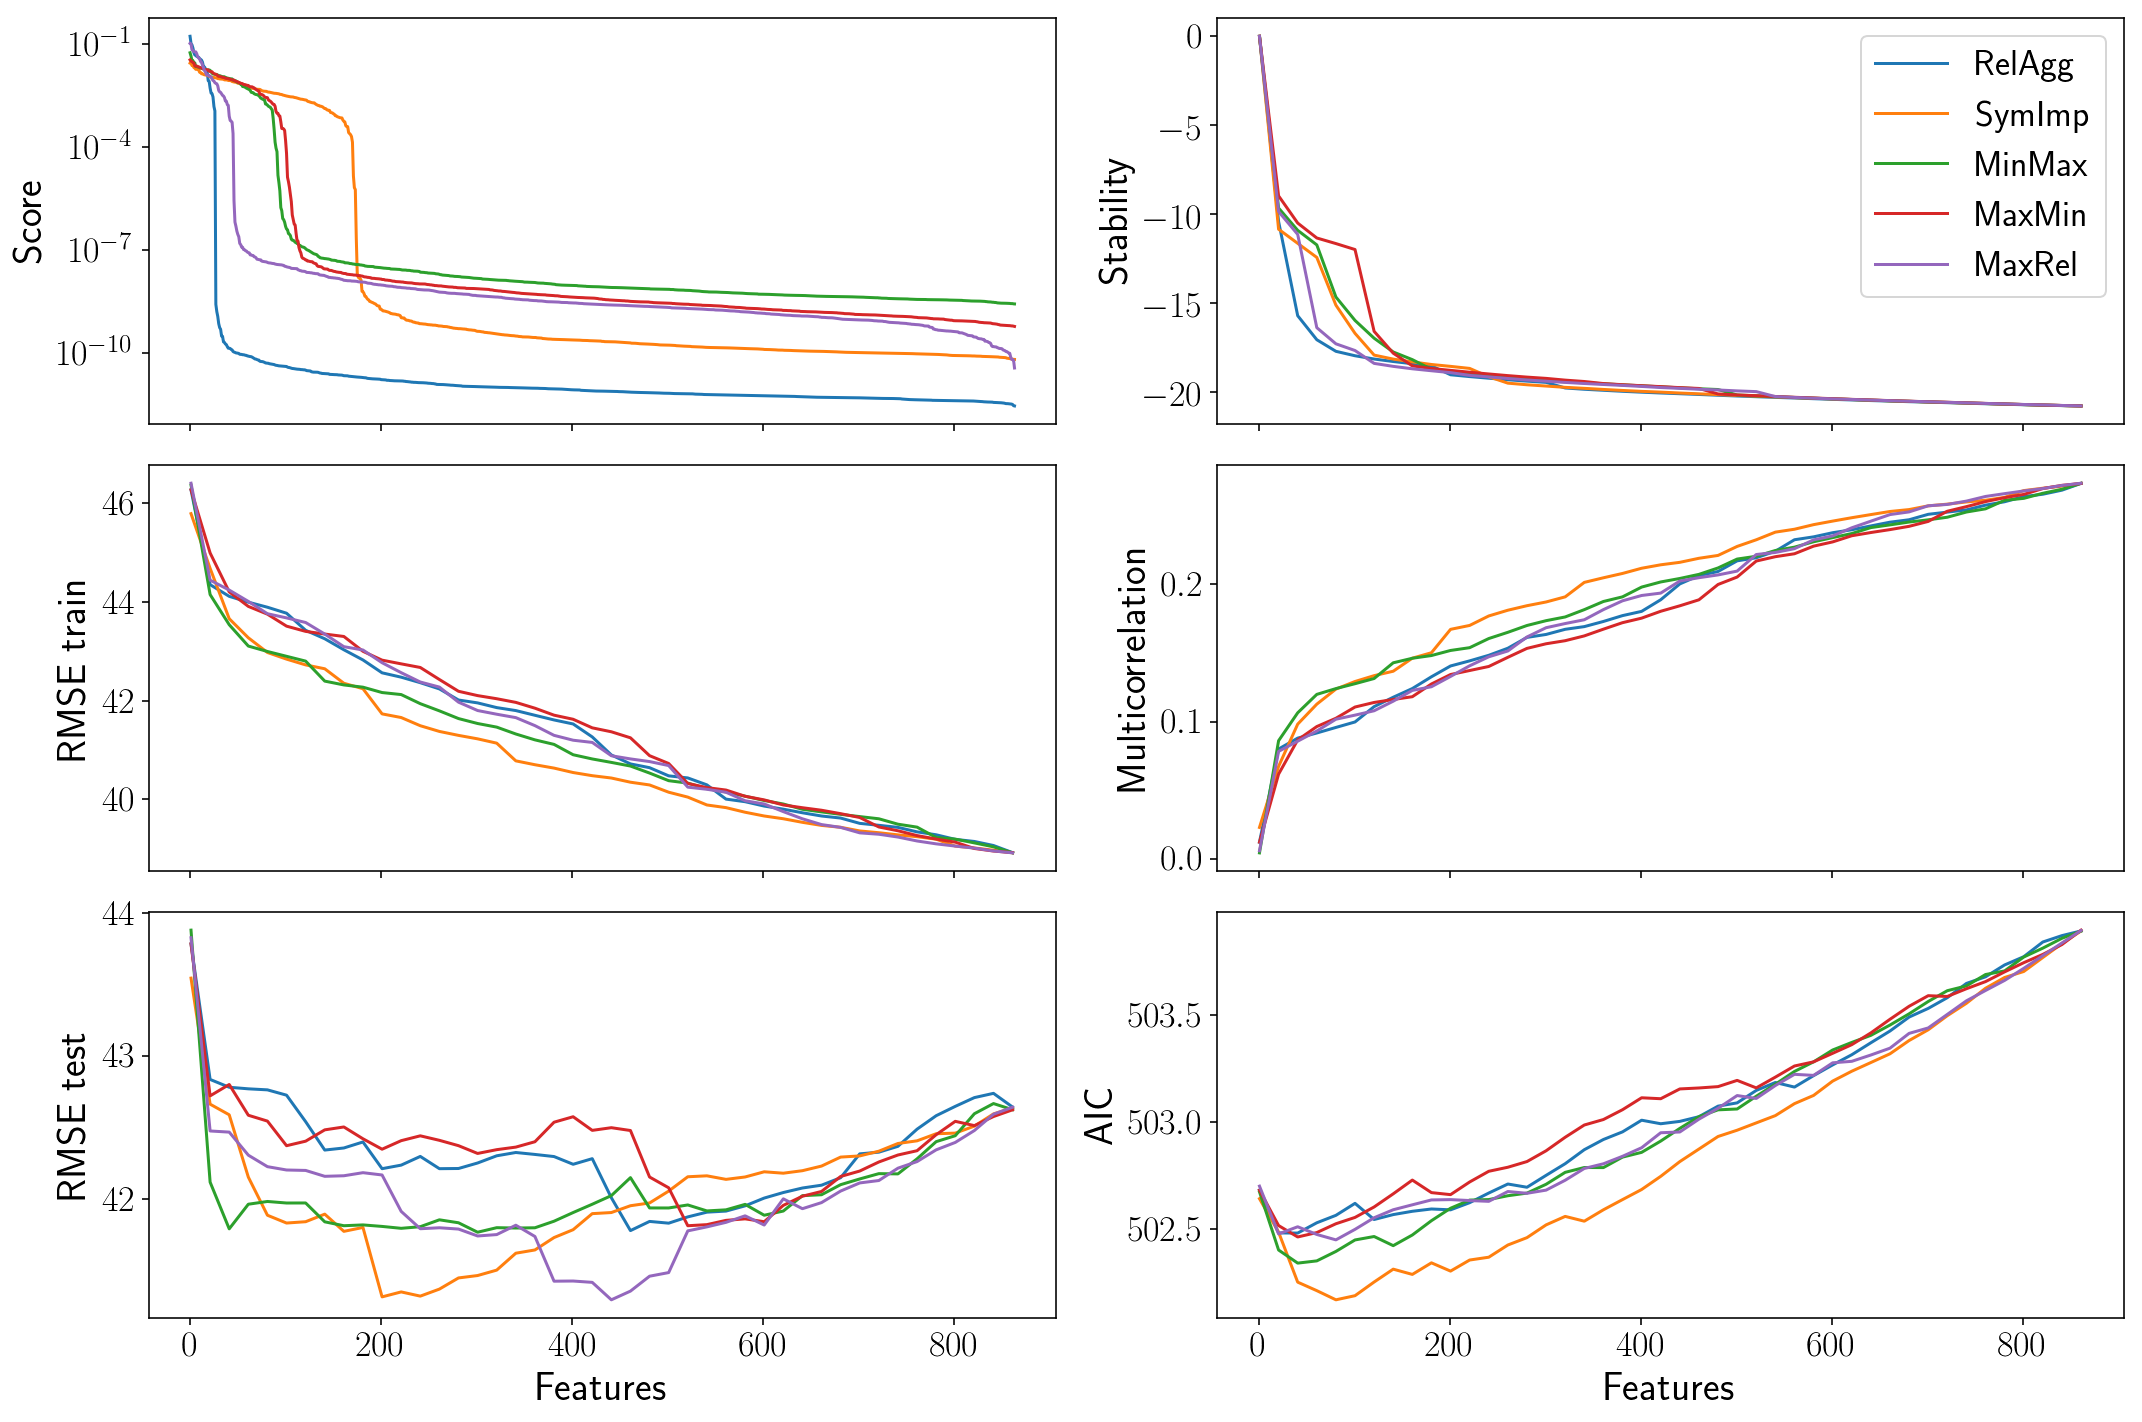

In [72]:
with open('res/qpfs_vs_mqpfs_ecog_3_{}_results.json'.format(step), 'r') as f:
    results = json.loads(f.read())

plot_metrics(results)